# Ligand Similarity per Fam
Look at distribution of Tanimoto coeffs for the Kinase groups and families.
You need to run `process_similarity_by_cluster.py` before running this notebook. 

In [1]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100"

## Setup

In [2]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from math import comb

In [3]:
def load_from_pkl(save_path: str) -> object:
    with open(save_path, "rb") as f:
        obj = pickle.load(f)
    return obj

## Overall Distribution

In [4]:
MIN_VAL = 0.0
MAX_VAL = 1.0

In [5]:
SIM_MAT = np.load(os.path.join(DATA_DIR, "compound_structures", "similarity_lower_triangular_matrix.npy"))

In [6]:
SIM_MAT.shape

(49945015,)

In [7]:
# calculating number of ligands from size of matrix
L = SIM_MAT.shape[0] # number of elements in lower-triangular mat
# from fact that N (N_LIGANDS) has relation: N^2 = N + 2L (also note L = N choose 2)
N_LIGANDS = (1 + np.sqrt(1 + (8 * L))) / 2
assert N_LIGANDS.is_integer()
print(N_LIGANDS)
N_LIGANDS = int(N_LIGANDS)

9995.0


In [8]:
scipy.stats.describe(SIM_MAT)

DescribeResult(nobs=49945015, minmax=(np.float64(0.0), np.float64(1.0)), mean=np.float64(0.13642800255772977), variance=np.float64(0.0027285236313576633), skewness=np.float64(3.3842191996351185), kurtosis=np.float64(26.476067212320135))

In [9]:
np.median(SIM_MAT)

np.float64(0.12871287128712872)

In [30]:
# extreme cases
# I've double-checked all SMILES values are unique, so some fingerprints must be near-identical
print("1.0 values:", (SIM_MAT == 1.0).sum())

1.0 values: 505


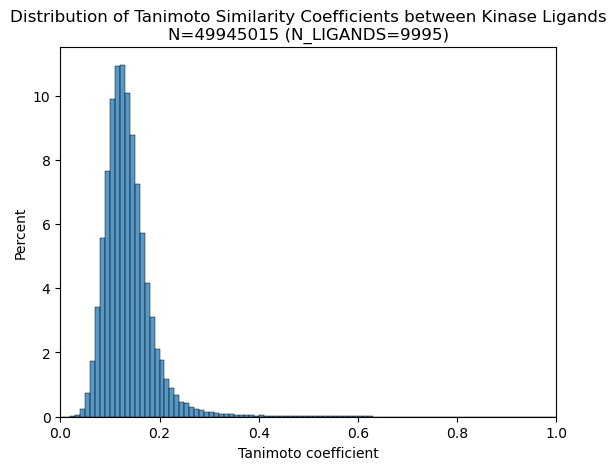

In [10]:
sns.histplot(SIM_MAT, bins=100, stat="percent")
plt.title(f"Distribution of Tanimoto Similarity Coefficients between Kinase Ligands\nN={L} (N_LIGANDS={N_LIGANDS})")
plt.xlabel("Tanimoto coefficient")
plt.xlim(MIN_VAL, MAX_VAL)
plt.show()

## Looking at distribution for kinase groups (class_level=4)

In [11]:
family_info_df = pl.read_csv(os.path.join(DATA_DIR,"targets/family_addl_info.tsv"), separator="\t")
family_info_df = family_info_df.with_columns((pl.col("short_name").str.to_uppercase()))

In [12]:
DICT_PATH_CL4 = os.path.join(DATA_DIR, "processed_similarity_cluster_data", f"cluster2sim_class_level=4.pkl")
cluster_dict_cl4 = load_from_pkl(DICT_PATH_CL4)

In [13]:
LC_PATH_CL4 = os.path.join(DATA_DIR, "family_clusters", "ligand2cluster-class_level=4.tsv")
ligand_cluster_cl4_df = pl.read_csv(LC_PATH_CL4, separator="\t")

In [14]:
ligand_cluster_cl4_df = ligand_cluster_cl4_df.join(family_info_df, on="protein_class_id")

In [15]:
ligand_cluster_cl4_df.head()

molregno,tid,protein_class_id,cluster,parent_id,pref_name,short_name,class_level
i64,i64,i64,i64,i64,str,str,i64
148,10044,158,2,1100,"""Other protein kinase group""","""OTHER""",4
213,10850,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
213,10850,1289,4,1100,"""AGC protein kinase group""","""AGC""",4
213,10839,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
213,11843,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4


In [16]:
# sanity checks
assert (len(cluster_dict_cl4.keys()) == ligand_cluster_cl4_df["cluster"].n_unique())
for cluster_tup, cluster_df in ligand_cluster_cl4_df.group_by("cluster"):
    cluster_id = cluster_tup[0]
    dict_n_pairs = len(cluster_dict_cl4[cluster_id])
    df_n_pairs = comb(cluster_df["molregno"].n_unique(), 2)
    assert dict_n_pairs == df_n_pairs, f"Mismatch with cluster={cluster_id} ({dict_n_pairs} != {df_n_pairs})"

In [17]:
cluster2name_df = ligand_cluster_cl4_df[["cluster", "short_name"]].unique().sort(by="cluster")
cluster2name_dict = dict(zip(cluster2name_df["cluster"], cluster2name_df["short_name"]))
cluster2name_dict

{1: 'CMGC',
 2: 'OTHER',
 3: 'TK',
 4: 'AGC',
 5: 'CK1',
 6: 'STE',
 7: 'TKL',
 8: 'CAMK',
 9: 'ATYPICAL'}

In [18]:
exclude_clusters = ["ATYPICAL", "OTHER"]
cluster_order = ['CK1', 'STE', 'CAMK', 'AGC', 'TKL', 'CMGC', 'TK'] # this is from the other notebook - just to make colors match short_name between plots

In [19]:
cl4_dict = {cluster2name_dict[k]: vals for k, vals in cluster_dict_cl4.items() if cluster2name_dict[k] not in exclude_clusters}

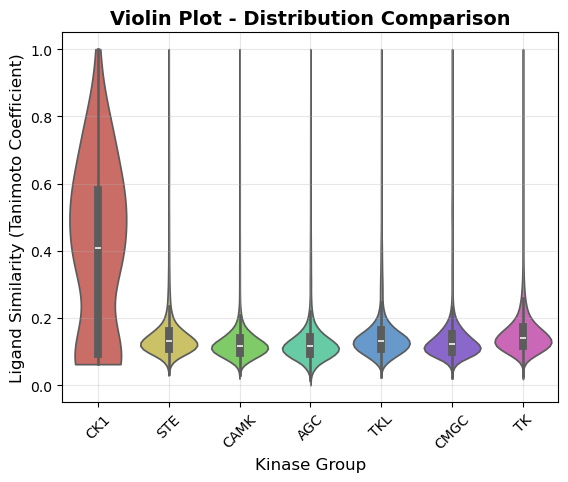

In [20]:
sns.violinplot(data=cl4_dict, palette='hls', cut=0, order=cluster_order, hue_order=cluster_order)
plt.title('Violin Plot - Distribution Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Kinase Group', fontsize=12)
plt.ylabel('Ligand Similarity (Tanimoto Coefficient)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

In [21]:
for k in cluster_order:
    print(k)
    print(scipy.stats.describe(cl4_dict[k]))
    print("-"*80)

CK1
DescribeResult(nobs=78, minmax=(np.float64(0.0625), np.float64(1.0)), mean=np.float64(0.4069574969016254), variance=np.float64(0.06442486713140454), skewness=np.float64(0.05493171665173159), kurtosis=np.float64(-1.016353152691315))
--------------------------------------------------------------------------------
STE
DescribeResult(nobs=90100, minmax=(np.float64(0.028846153846153848), np.float64(1.0)), mean=np.float64(0.1524652390883242), variance=np.float64(0.008845248191940097), skewness=np.float64(4.04124785895686), kurtosis=np.float64(20.20859103564336))
--------------------------------------------------------------------------------
CAMK
DescribeResult(nobs=177906, minmax=(np.float64(0.019801980198019802), np.float64(1.0)), mean=np.float64(0.13276843531736057), variance=np.float64(0.00694770877081679), skewness=np.float64(4.894920888203396), kurtosis=np.float64(29.897088117979905))
--------------------------------------------------------------------------------
AGC
DescribeResul

## Distribution for kinase families (class_level=5)

In [22]:
DICT_PATH_CL5 = os.path.join(DATA_DIR, "processed_similarity_cluster_data", f"cluster2sim_class_level=5.pkl")
cluster_dict_cl5 = load_from_pkl(DICT_PATH_CL5)

In [23]:
MIN_N_OBS = 5

In [24]:
mean_vals = [np.mean(l) for l in cluster_dict_cl5.values() if len(l) > MIN_N_OBS]
median_vals = [np.median(l) for l in cluster_dict_cl5.values() if len(l) > MIN_N_OBS]

In [25]:
print(len(mean_vals))
print(len(cluster_dict_cl5)) # not all clusters have enough observations

72
86


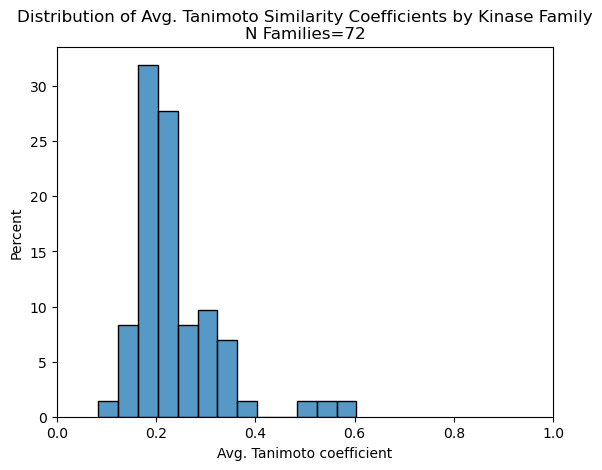

In [26]:
sns.histplot(mean_vals, stat="percent")
plt.title(f"Distribution of Avg. Tanimoto Similarity Coefficients by Kinase Family\nN Families={len(mean_vals)}")
plt.xlabel("Avg. Tanimoto coefficient")
plt.xlim(MIN_VAL, MAX_VAL)
plt.show()

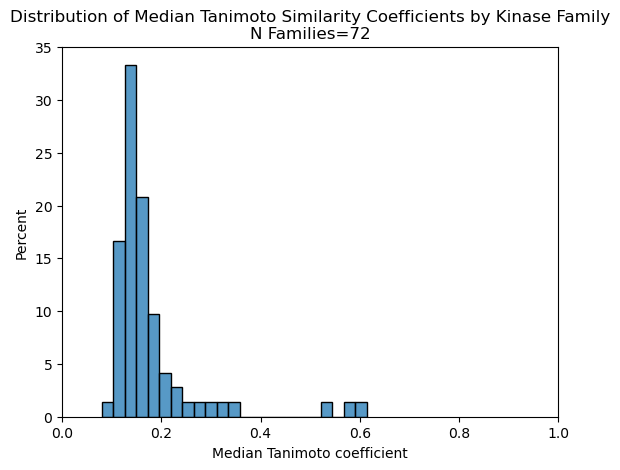

In [27]:
sns.histplot(median_vals, stat="percent")
plt.title(f"Distribution of Median Tanimoto Similarity Coefficients by Kinase Family\nN Families={len(median_vals)}")
plt.xlabel("Median Tanimoto coefficient")
plt.xlim(MIN_VAL, MAX_VAL)
plt.show()